In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error
import random


In [5]:

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define paths and parameters
DATASET_PATH = r"C:\Users\keshav\Videos\mm\LPV\dataset\UTKFace"
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 10


In [7]:
# Cell 2: Function to load and preprocess UTKFace data
def load_utkface_data():
    images = []
    ages = []
    genders = []
    invalid_files = 0
    
    # Check if path exists
    if not os.path.exists(DATASET_PATH):
        raise FileNotFoundError(f"Dataset path {DATASET_PATH} does not exist")
    
    print(f"Scanning directory: {DATASET_PATH}")
    files = [f for f in os.listdir(DATASET_PATH) if f.endswith('.jpg')]
    print(f"Found {len(files)} .jpg files")
    
    for filename in files:
        parts = filename.split('_')
        if len(parts) >= 2:
            try:
                age = int(parts[0])
                gender = int(parts[1])
                if 0 <= age <= 120 and gender in [0, 1]:
                    img_path = os.path.join(DATASET_PATH, filename)
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Failed to load image: {filename}")
                        invalid_files += 1
                        continue
                    img = cv2.resize(img, IMG_SIZE)
                    img = img / 255.0  # Normalize to [0,1]
                    images.append(img)
                    ages.append(age)
                    genders.append(gender)
                else:
                    invalid_files += 1
            except (ValueError, IndexError):
                print(f"Invalid filename format: {filename}")
                invalid_files += 1
                continue
    
    print(f"Loaded {len(images)} valid images, skipped {invalid_files} invalid files")
    if len(images) == 0:
        raise ValueError("No valid images loaded. Check dataset path and file formats.")
    
    return np.array(images), np.array(ages), np.array(genders)

# Load data
try:
    images, ages, genders = load_utkface_data()
    print(f"Loaded {len(images)} images")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Scanning directory: C:\Users\keshav\Videos\mm\LPV\dataset\UTKFace
Found 23708 .jpg files
Loaded 23708 valid images, skipped 0 invalid files
Loaded 23708 images


In [9]:
# Cell 3: Split data into training and testing sets
X_train, X_test, y_age_train, y_age_test, y_gender_train, y_gender_test = train_test_split(
    images, ages, genders, test_size=0.2, random_state=42
)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 18966, Testing samples: 4742


In [11]:
# Cell 4: Build multi-output CNN model
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
inputs = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Gender output
gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)

# Age output
age_output = Dense(1, activation='linear', name='age_output')(x)

# Define and compile model
model = Model(inputs=inputs, outputs=[gender_output, age_output])
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={'gender_output': 'binary_crossentropy', 'age_output': 'mse'},
    metrics={'gender_output': 'accuracy', 'age_output': 'mae'}
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32768)     │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  8,388,864 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │        257 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 1)         │        257 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,482,626 (32.36 MB)

 Trainable params: 8,482,626 (32.36 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Cell 5: Train the model
history = model.fit(
    X_train,
    {'gender_output': y_gender_train, 'age_output': y_age_train},
    validation_data=(X_test, {'gender_output': y_gender_test, 'age_output': y_age_test}),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Cell 6: Evaluate the model
gender_pred, age_pred = model.predict(X_test)
gender_pred_binary = (gender_pred > 0.5).astype(int).flatten()
age_pred = age_pred.flatten()

# Gender evaluation
print("\nGender Classification Report:")
print(classification_report(y_gender_test, gender_pred_binary, target_names=['Male', 'Female']))

# Age evaluation
mae = mean_absolute_error(y_age_test, age_pred)
print(f"\nAge Prediction MAE: {mae:.2f} years")

Epoch 1/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 142s 233ms/step - age_output_loss: 417.5315 - age_output_mae: 15.4321 - gender_output_accuracy: 0.5336 - gender_output_loss: 1.3702 - loss: 418.9018 - val_age_output_loss: 162.8428 - val_age_output_mae: 9.8395 - val_gender_output_accuracy: 0.7056 - val_gender_output_loss: 0.5903 - val_loss: 163.5775
Epoch 2/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 130s 219ms/step - age_output_loss: 180.5307 - age_output_mae: 10.2001 - gender_output_accuracy: 0.6413 - gender_output_loss: 0.6475 - loss: 181.1782 - val_age_output_loss: 124.4333 - val_age_output_mae: 8.3126 - val_gender_output_accuracy: 0.6797 - val_gender_output_loss: 0.6001 - val_loss: 125.1258
Epoch 3/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 129s 218ms/step - age_output_loss: 149.3005 - age_output_mae: 9.2226 - gender_output_accuracy: 0.6453 - gender_output_loss: 0.6391 - loss: 149.9395 - val_age_output_loss: 110.9686 - val_age_output_mae: 7.9095 - val_gender_output_accuracy: 0.7408 - val_gender_output_loss: 0.5583

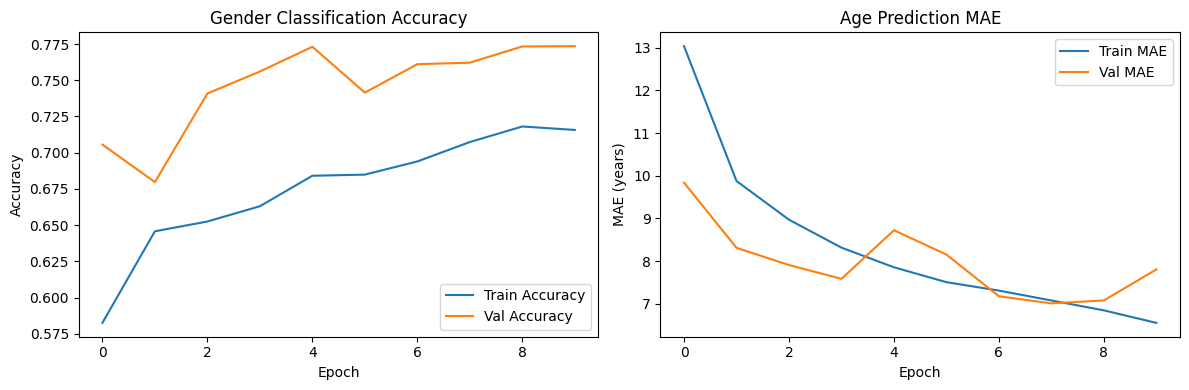

Training history plot saved as 'training_history.png'


<Figure size 640x480 with 0 Axes>

In [15]:
# Cell 7: Plot training history
plt.figure(figsize=(12, 4))

# Gender accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['gender_output_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_gender_output_accuracy'], label='Val Accuracy')
plt.title('Gender Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Age MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['age_output_mae'], label='Train MAE')
plt.plot(history.history['val_age_output_mae'], label='Val MAE')
plt.title('Age Prediction MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE (years)')
plt.legend()

plt.tight_layout()
plt.show()

# Save plot
plt.savefig('training_history.png')
print("Training history plot saved as 'training_history.png'")

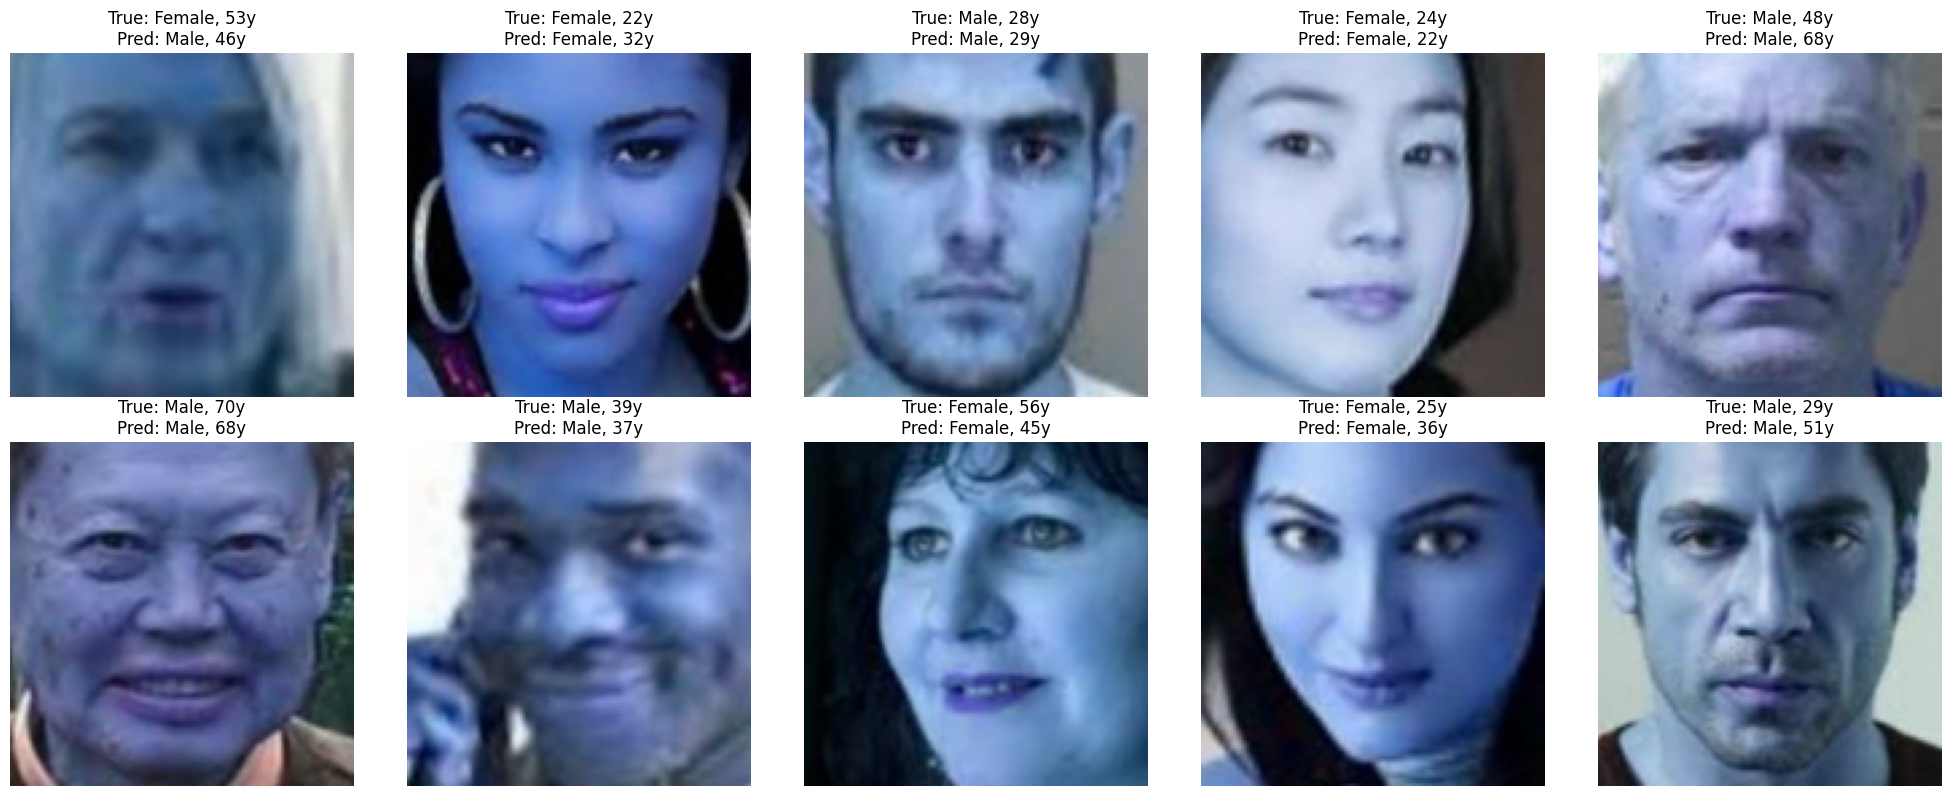

Sample predictions plot saved as 'sample_predictions.png'


<Figure size 640x480 with 0 Axes>

In [17]:
# Cell 8: Display 10 sample predictions
random_indices = random.sample(range(len(X_test)), 10)
plt.figure(figsize=(20, 8))

for i, idx in enumerate(random_indices):
    img = X_test[idx]
    true_gender = 'Male' if y_gender_test[idx] == 0 else 'Female'
    pred_gender = 'Male' if gender_pred_binary[idx] == 0 else 'Female'
    true_age = y_age_test[idx]
    pred_age = age_pred[idx]
    
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_gender}, {true_age}y\nPred: {pred_gender}, {int(pred_age)}y")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Save plot
plt.savefig('sample_predictions.png')
print("Sample predictions plot saved as 'sample_predictions.png'")

In [23]:
# Age MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['age_output_mae'], label='Train MAE')
plt.plot(history.history['val_age_output_mae'], label='Val MAE')
plt.title('Age Prediction MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE (years)')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.close()

In [25]:
# Display 10 sample predictions
random_indices = random.sample(range(len(X_test)), 10)
plt.figure(figsize=(20, 8))

for i, idx in enumerate(random_indices):
    img = X_test[idx]
    true_gender = 'Male' if y_gender_test[idx] == 0 else 'Female'
    pred_gender = 'Male' if gender_pred_binary[idx] == 0 else 'Female'
    true_age = y_age_test[idx]
    pred_age = age_pred[idx]
    
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_gender}, {true_age}y\nPred: {pred_gender}, {int(pred_age)}y")
    plt.axis('off')

plt.tight_layout()
plt.savefig('sample_predictions.png')
plt.close()

print("\nTraining history plot saved as 'training_history.png'")
print("Sample predictions plot saved as 'sample_predictions.png'")


Training history plot saved as 'training_history.png'
Sample predictions plot saved as 'sample_predictions.png'
